In [27]:
import matplotlib.pyplot as plt
import time
from pathlib import Path
import cv2
import torch
from numpy import random
from models.experimental import attempt_load
from utils.datasets import LoadImages
from utils.general import check_img_size, non_max_suppression, apply_classifier, \
    scale_coords, set_logging
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized

In [28]:
%matplotlib inline

In [29]:
# Función para mostrar imagen con matplotlib
def show_image(img, detections, names, colors):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
    print("Detected objects:")
    for *xyxy, conf, cls in detections:
        label = f'{names[int(cls)]} {conf:.2f}'
        print(f'{label}')

def detect_single_image(image_path, weights, img_size=640, conf_threshold=0.25, iou_threshold=0.45):
    source, weights, imgsz = image_path, weights, img_size

    # Initialize
    set_logging()
    device = select_device()
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size

    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    dataset = LoadImages(source, img_size=imgsz, stride=stride)

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    old_img_w = old_img_h = imgsz
    old_img_b = 1

    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Warmup
        if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
            old_img_b = img.shape[0]
            old_img_h = img.shape[2]
            old_img_w = img.shape[3]
            for i in range(3):
                model(img, augment=True)[0]

        # Inference
        t1 = time_synchronized()
        with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
            pred = model(img, augment=True)[0]
        t2 = time_synchronized()

        # Apply NMS
        pred = non_max_suppression(pred, conf_threshold, iou_threshold, classes=0, agnostic=True)
        t3 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path# img.txt
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    label = f'{names[int(cls)]} {conf:.2f}'
                    print(label)
                    plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=1)

            # Print time (inference + NMS)
            print(f'{s}Done. ({(1E3 * (t2 - t1)):.1f}ms) Inference, ({(1E3 * (t3 - t2)):.1f}ms) NMS')

            #cv2.imshow(str(p), im0)
            #cv2.waitKey(1)  # 1 millisecond
            
            plt.imshow(im0)
            plt.axis('off')
            plt.show()


YOLOR  2022-12-11 torch 1.12.1+cu113 CUDA:0 (NVIDIA GeForce GTX 1060 6GB, 6143.75MB)



Fusing layers... 
IDetect.fuse


Model Summary: 208 layers, 6007596 parameters, 0 gradients, 13.0 GFLOPS


Placa 0.63
1 Placa, Done. (31.5ms) Inference, (1.5ms) NMS


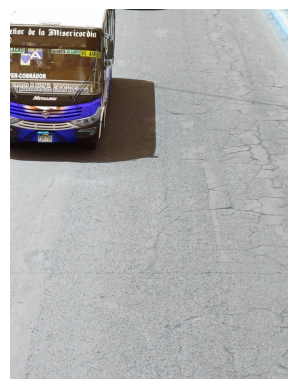

In [30]:
image_path = './images/valid/images/Foto-Placa-59-.rf.52b6ce4726b5aec4eb81931edf620a4b.jpg'  
weights_path = './models/yolov7-tiny_placas_1.pt'

with torch.no_grad():
        detect_single_image(image_path, weights=weights_path)
